In [1]:
%matplotlib widget

import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../dataset_generator/")
from environments import Environments

import umap
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("project_style.mplstyle")

import stats
import analysis_tools

In [2]:
def plot_3d_proj(data, tags = None, cmap = "viridis", title = "", axes = None):
    if axes is None:
        fig = plt.figure(figsize = (6,6))
        ax = fig.add_subplot(projection='3d')
    else:
        ax = axes
    ax.set_title(title)
    ax.scatter(xs=data[:,0], ys=data[:,1], zs=data[:,2], c = tags, s =0.5, alpha = 0.7, cmap = cmap, edgecolors=None)
    ax.axis("off")
    
    if axes is None:
        return fig    

In [3]:
def fit_umap(data, components = 2):
    fit = umap.UMAP(n_components = components)
    transformed = fit.fit_transform(data)
    return transformed

In [4]:
model_name = f"../models/al1_10_l2_0"
path = f"../models/{model_name}"
model, params = analysis_tools.load_model(path, device = "cpu", model_type = "RNN")

In [5]:
env = Environments()
sequence = list(env.envs)
n_envs = len(sequence)
limits = 1.1*np.array([-1.5, 1.5, -1.5, 1.5])

timesteps = 10000

In [6]:
x, r, v, c = analysis_tools.test_dataset(sequence, timesteps = timesteps, context = params["context"])

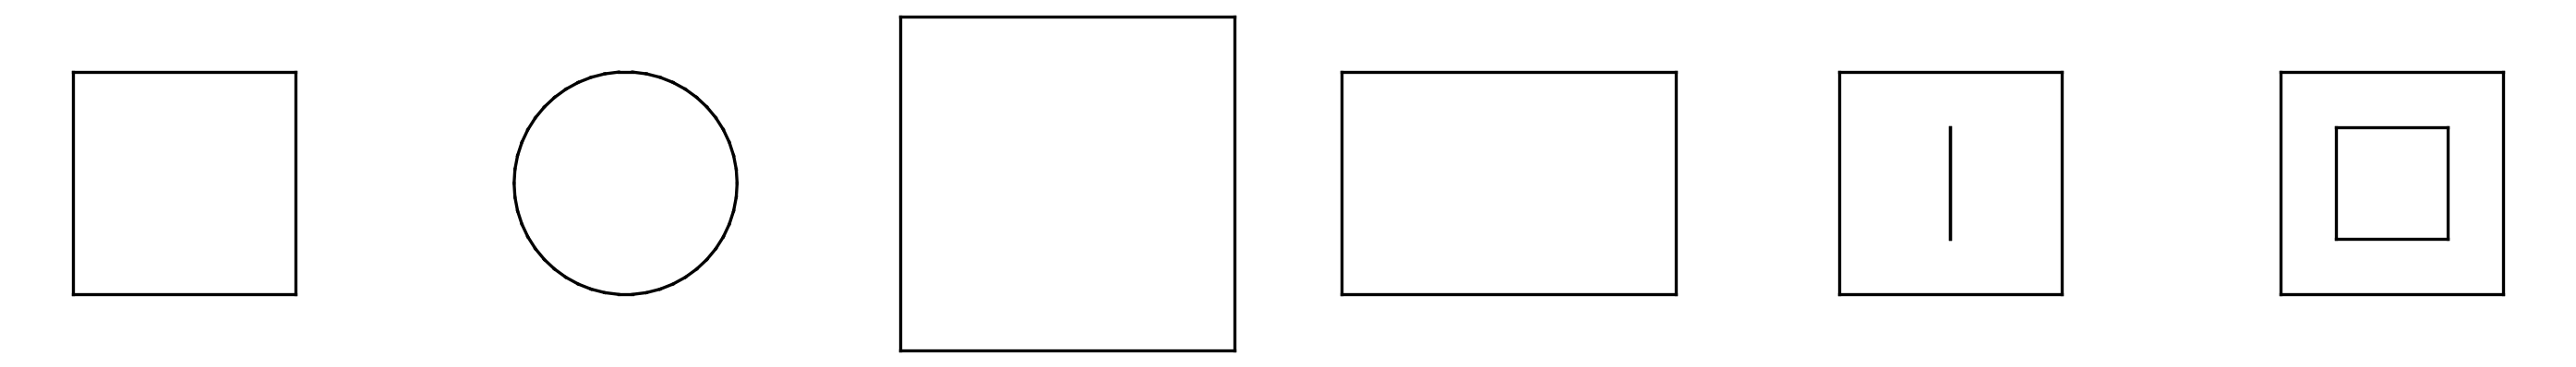

In [7]:
# plot the sequence walls
figsize = [len(sequence)*2, 2]
fig,axs = plt.subplots(1, len(sequence), figsize =figsize)
for i, wall in enumerate(sequence):
    axs[i].plot(*env.envs[wall].T, "k")
    axs[i].axis(limits)
    axs[i].set_aspect("equal")
    axs[i].axis("off")

In [8]:
dataset = [((x[0][i,None], x[1][i,None]), x[1][i,None]) for i in range(len(sequence))] # repackage
gs, ps, centers, preds = model.inference(dataset)

In [9]:
ps.shape, gs.shape

((6, 10000, 100), (6, 10000, 500))

In [10]:
# transformed_gc = fit_umap(gs.reshape(-1, gs.shape[-1]))
# transformed_pc = fit_umap(ps.reshape(-1, ps.shape[-1]))
transformed_pc = np.array([fit_umap(p) for p in ps])
transformed_pc = transformed_pc.reshape(-1, transformed_pc.shape[-1])
transformed_gc = np.array([fit_umap(g) for g in gs])
transformed_gc = transformed_gc.reshape(-1, transformed_gc.shape[-1])


In [11]:
col = np.argmax(x[0][...,2:].detach().numpy(), axis = -1)/len(sequence) # context signal
cmap = matplotlib.colormaps['viridis']
c = np.zeros((len(sequence), col.shape[1], 4))
for i, val in enumerate(np.linspace(0, 1, 6)):
    c[i] = col.shape[1]*[cmap(val)]

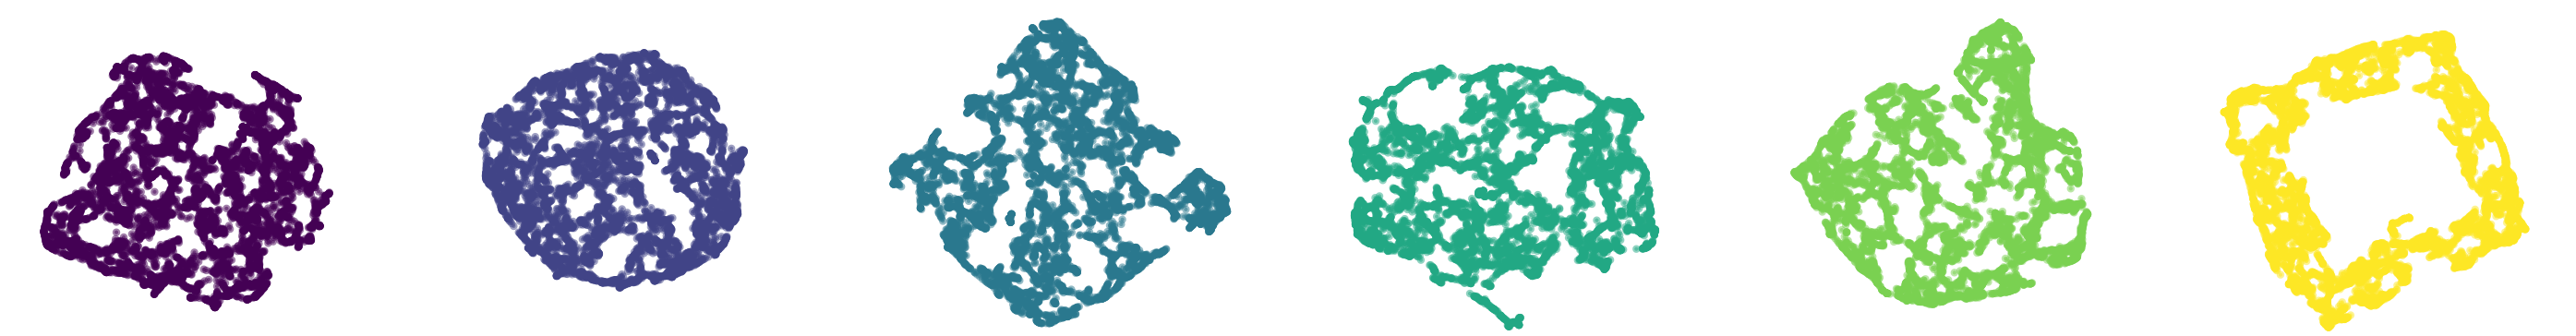

In [12]:
p2 = transformed_pc.reshape(ps.shape[0], ps.shape[1], -1)
fig,axs = plt.subplots(1, len(sequence), figsize =figsize)
mins = np.amin(transformed_pc, axis = 0)
maxs = np.amax(transformed_pc, axis = 0)
lim = np.array([mins[0], maxs[0], mins[1], maxs[1]])*1.1

for i in range(len(sequence)):
    axs[i].scatter(p2[i,:,0], p2[i,:,1], s = 1, alpha = 0.5, c = c[i])
    axs[i].axis(lim)
    axs[i].axis("off")
    axs[i].set_aspect("equal")
plt.show()
# fig.savefig("./figures/p_lowdim_2D")

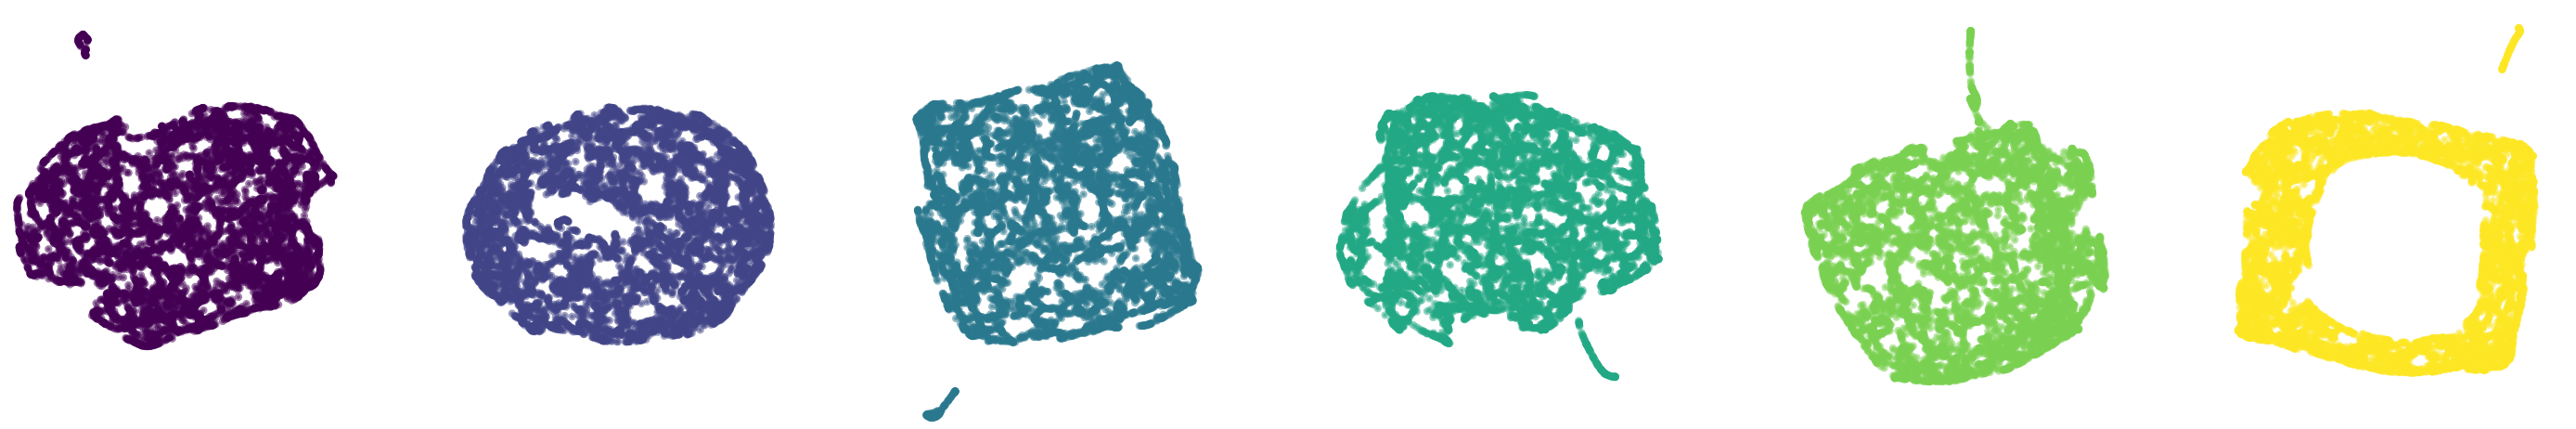

In [13]:
g2 = transformed_gc.reshape(gs.shape[0], gs.shape[1], -1)
fig,axs = plt.subplots(1, len(sequence), figsize =figsize)

mins = np.amin(transformed_gc, axis = 0)
maxs = np.amax(transformed_gc, axis = 0)
lim = np.array([mins[0], maxs[0], mins[1], maxs[1]])*1.1
for i in range(len(sequence)):
    axs[i].scatter(g2[i,:,0], g2[i,:,1], s = 1, alpha = 0.5, c = c[i])
    axs[i].axis(lim)
    axs[i].axis("off")
    axs[i].set_aspect("equal")
plt.show()
# fig.savefig("./figures/g_lowdim_2D")

In [14]:
transformed_gc_3D = fit_umap(np.reshape(gs, (-1, gs.shape[-1])), 3) # Try 3D
transformed_pc_3D = fit_umap(np.reshape(ps, (-1, ps.shape[-1])), 3)

/tmp/ipykernel_715396/1496740684.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(xs=data[:,0], ys=data[:,1], zs=data[:,2], c = tags, s =0.5, alpha = 0.7, cmap = cmap, edgecolors=None)


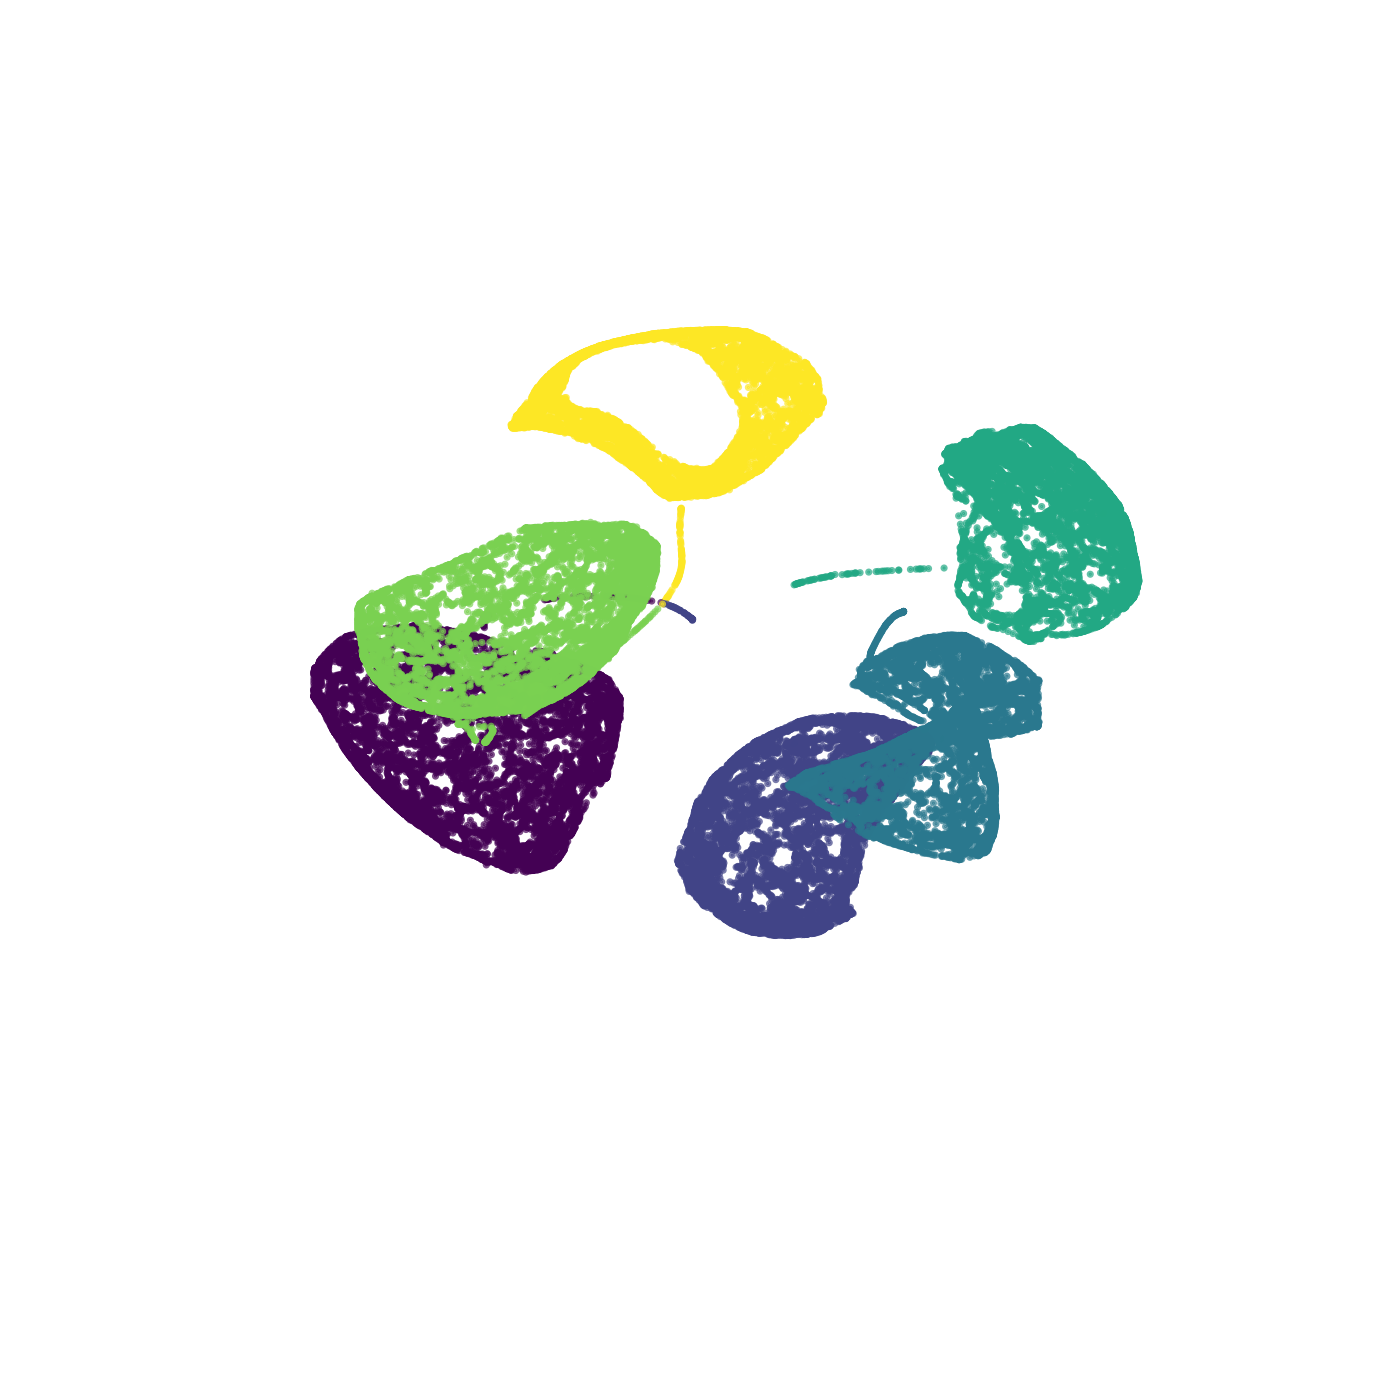

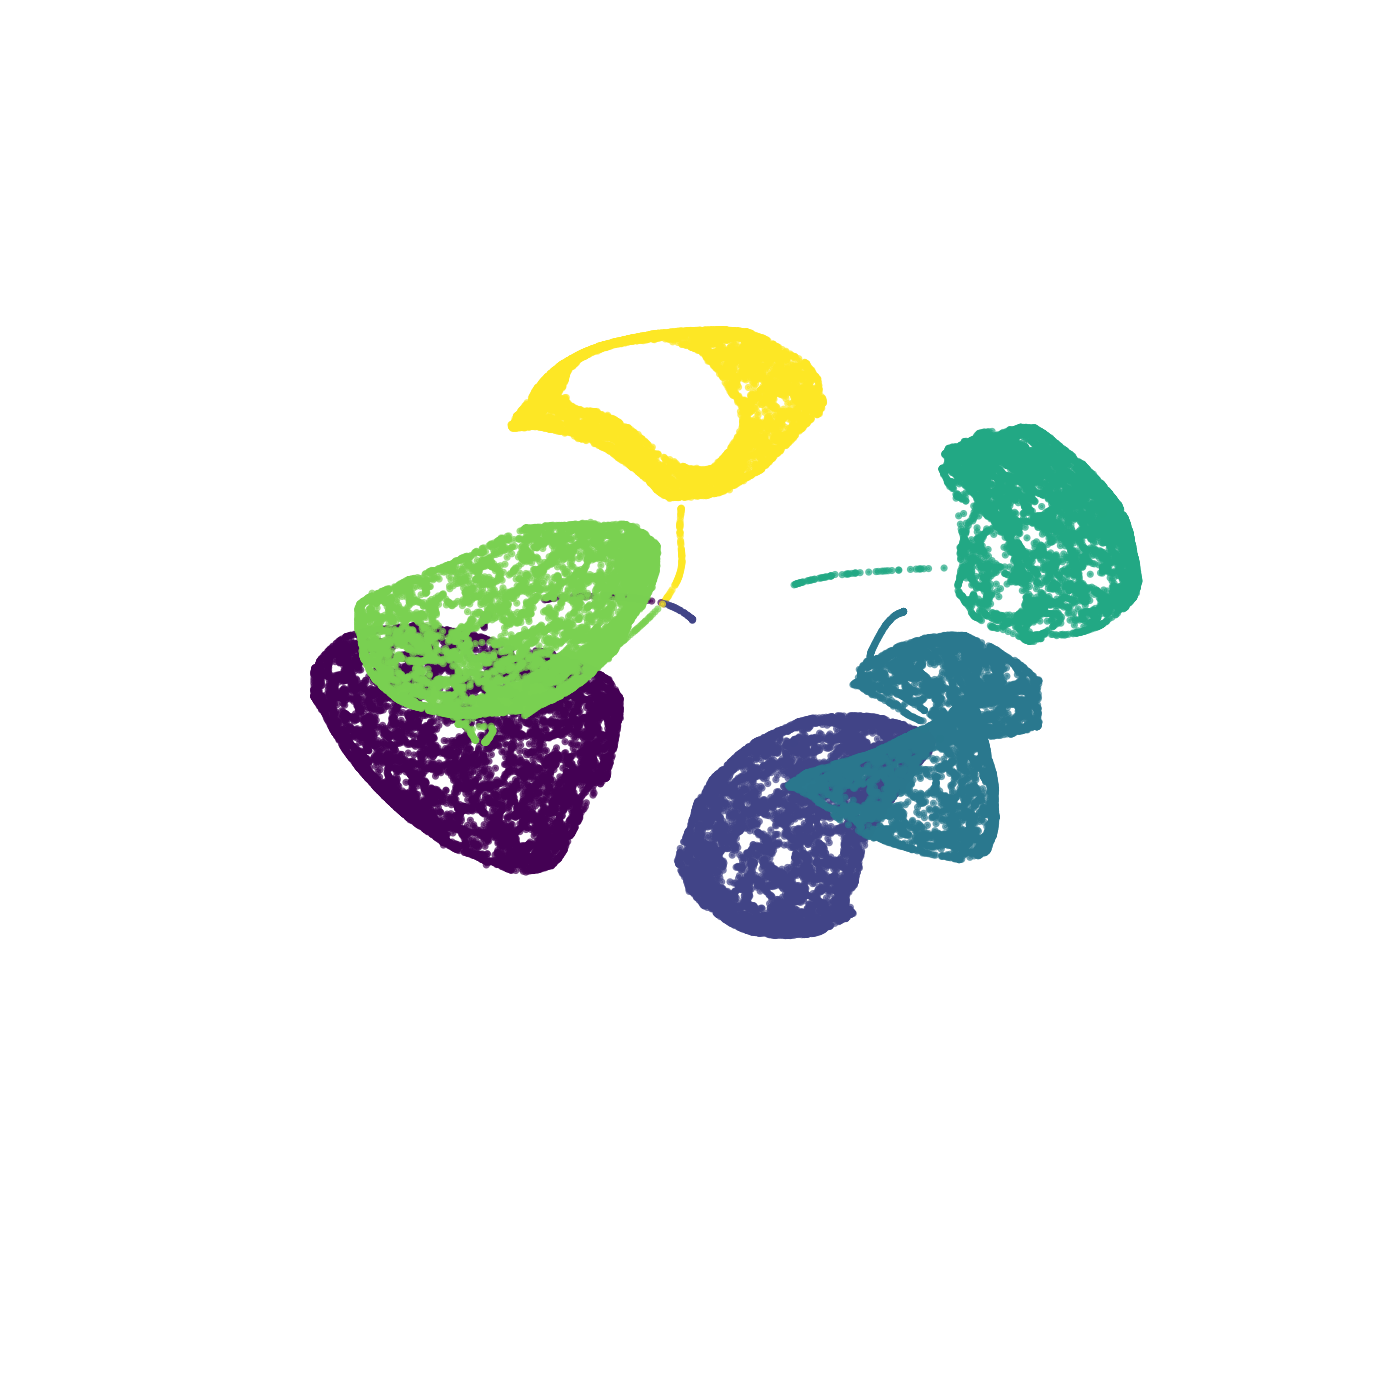

In [15]:
plot_3d_proj(transformed_gc_3D, tags = c.reshape(-1, c.shape[-1]))

/tmp/ipykernel_715396/1496740684.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(xs=data[:,0], ys=data[:,1], zs=data[:,2], c = tags, s =0.5, alpha = 0.7, cmap = cmap, edgecolors=None)


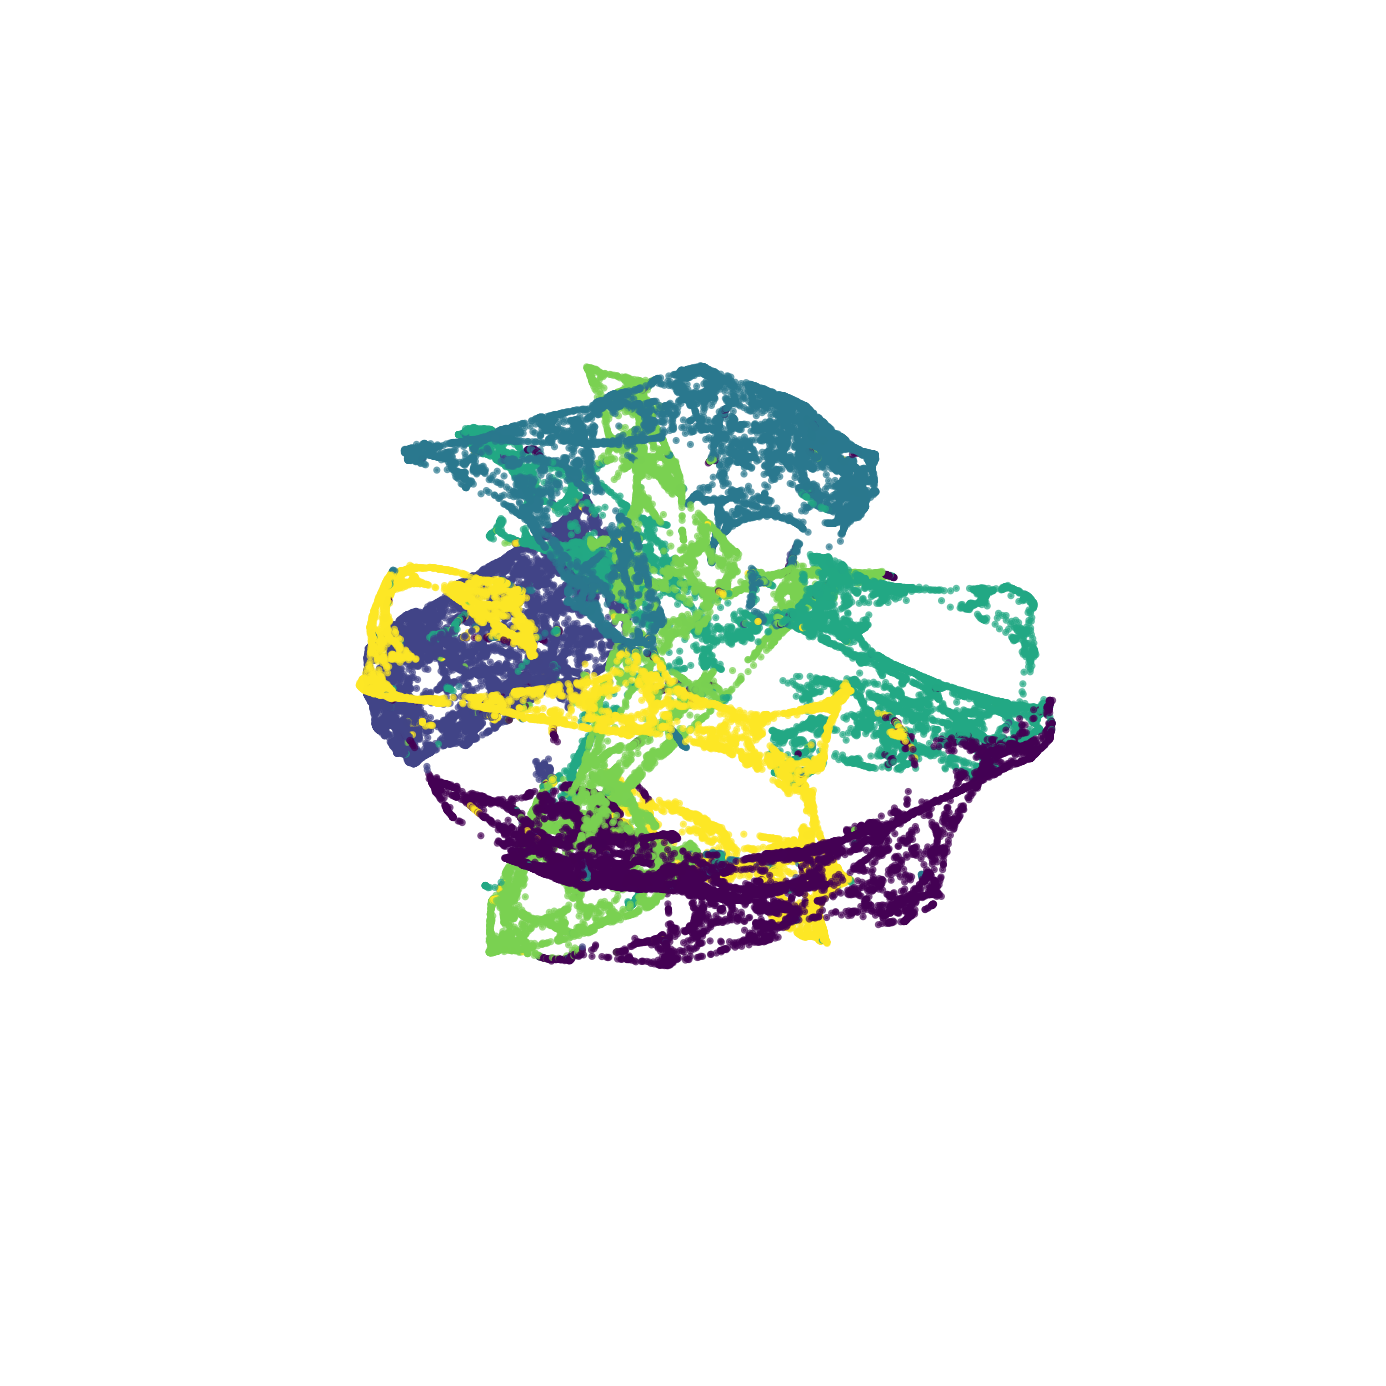

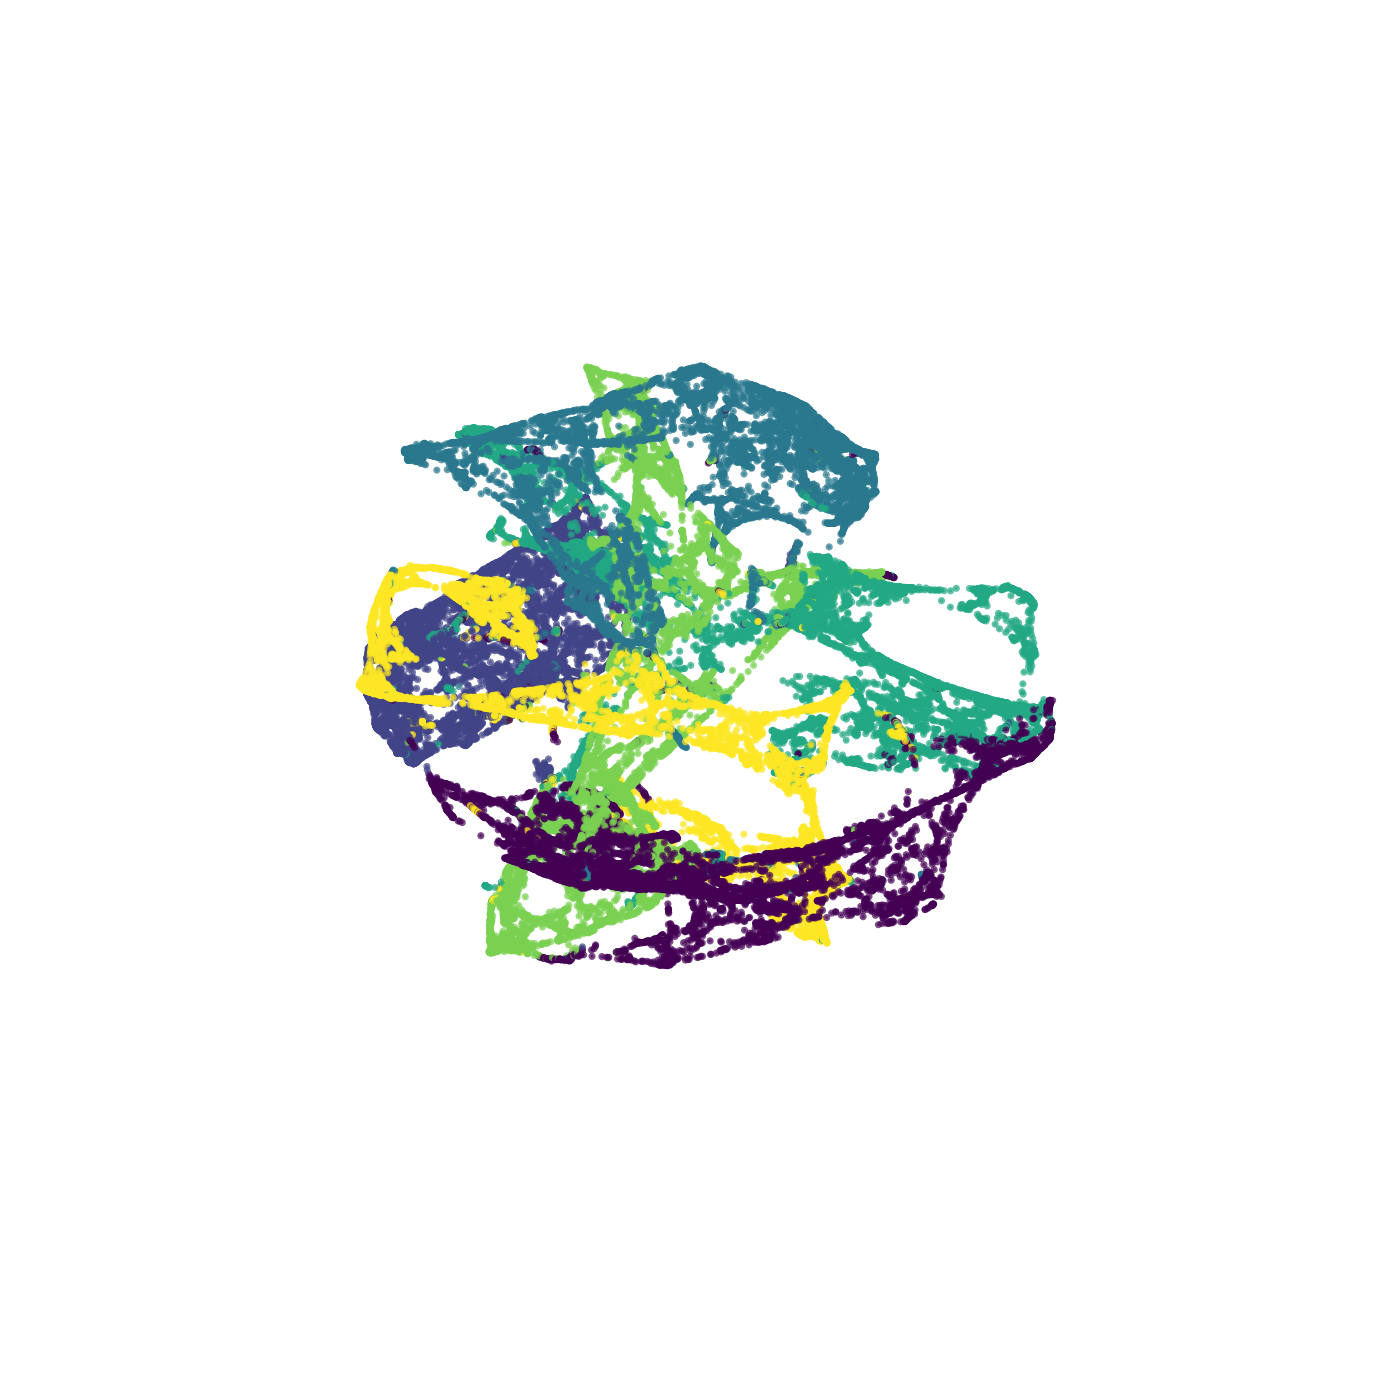

In [16]:
plot_3d_proj(transformed_pc_3D, tags = c.reshape(-1, c.shape[-1]))

In [17]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [18]:
def perform_pca(data, nc):
    # Center the data by subtracting the mean
    #data_centered = data - np.mean(data, axis=0)
    
    # Perform PCA
    pca = PCA(n_components=nc)
    pca_model = pca.fit(data)
    # Get the explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    
    # Calculate cumulative explained variance
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)
    
    return pca_model, explained_variance_ratio, cumulative_explained_variance

In [19]:
n_components = 50

pca_env = 0#np.arange(len(sequence))


/tmp/ipykernel_715396/3673203927.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(2,2, figsize = (3, 3))


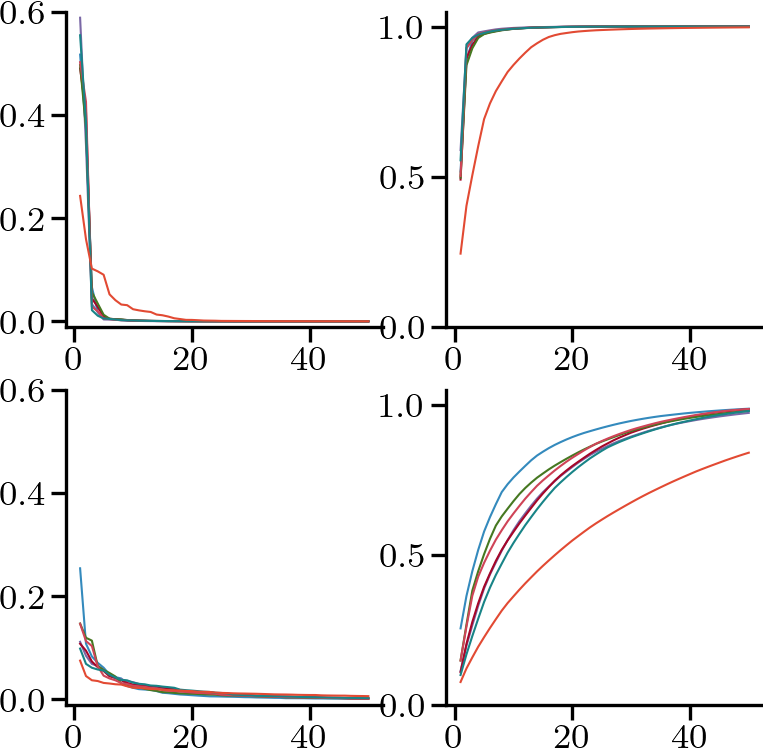

In [34]:
fig, ax = plt.subplots(2,2, figsize = (3, 3))

for i in range(len(sequence)+ 1):

    if i == len(sequence):
        ind = np.arange(len(sequence))
    else:
        ind = i

    g_pca = PCA(n_components=n_components).fit(gs[ind].reshape(-1, gs.shape[-1]))
    p_pca = PCA(n_components=n_components).fit(ps[ind].reshape(-1, ps.shape[-1]))

    for j, var in enumerate((g_pca.explained_variance_ratio_, p_pca.explained_variance_ratio_)):
        ax[j,0].plot(np.arange(1, len(var)+1), var, "-", markersize = 0.5, linewidth = 0.5)
        ax[j,1].plot(np.arange(1, len(var)+1), np.cumsum(var), "-", markersize = 0.25, linewidth = 0.5)
        ax[j,0].set_ylim(-0.01, 0.6)
        ax[j,1].set_ylim(0, 1.05)


In [21]:
try:
    gt, pt, rt # feel free to hate this
except:
    x, rt, _, _ = analysis_tools.test_dataset(sequence, timesteps = timesteps, context = params["context"])
    dataset = [((x[0][i,None], x[1][i,None]), x[1][i,None]) for i in range(len(sequence))] # repackage
    gt, pt, centers, preds = model.inference(dataset)

(<Figure size 1500x1500 with 25 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

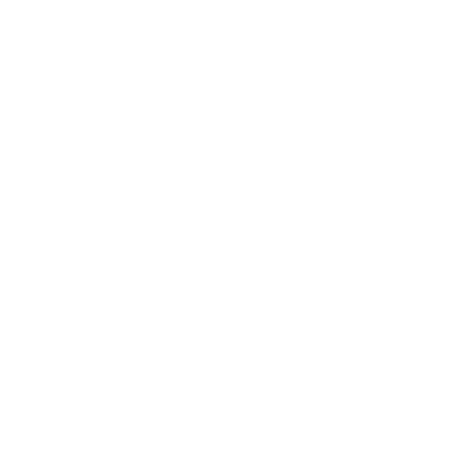

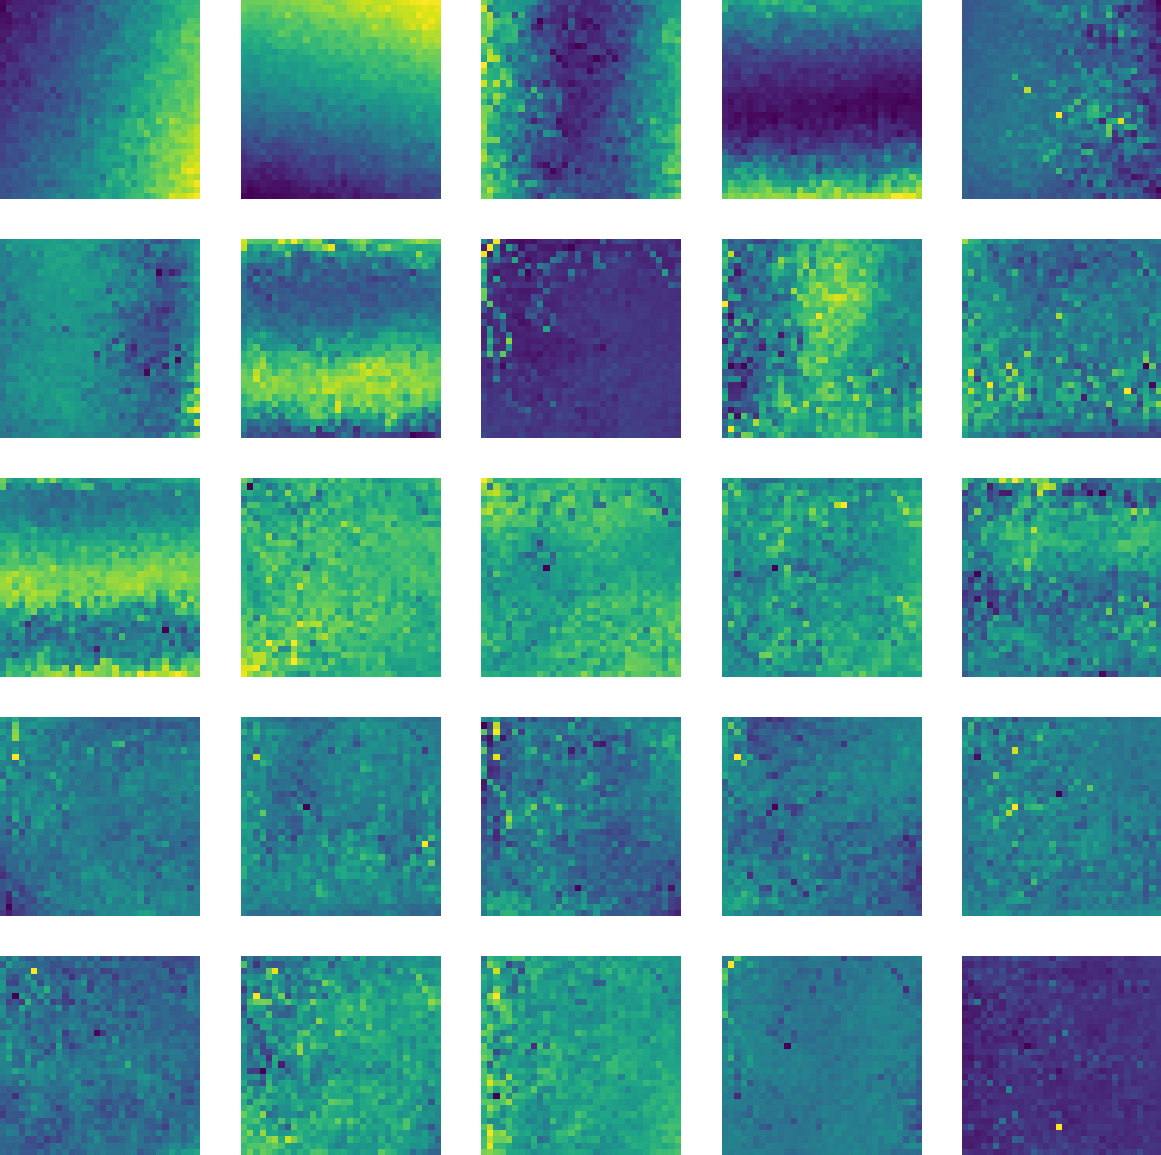

In [22]:
result = g_pca.transform(gt[pca_env].reshape(-1, gt.shape[-1]))
ratemaps = stats.ratemaps(result[None], rt[pca_env].reshape(-1, rt.shape[-1])[None], bins = [32,32])
plt.figure()
analysis_tools.plot_ensemble(ratemaps[0], 5)

(<Figure size 1500x1500 with 25 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

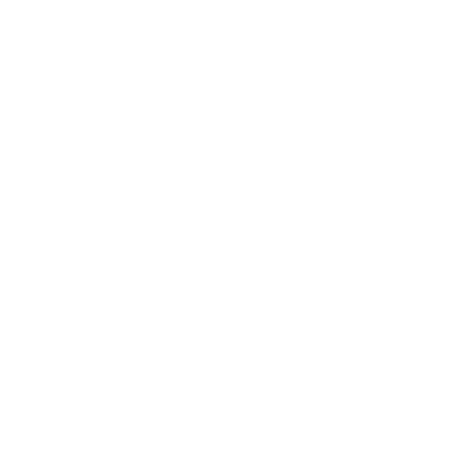

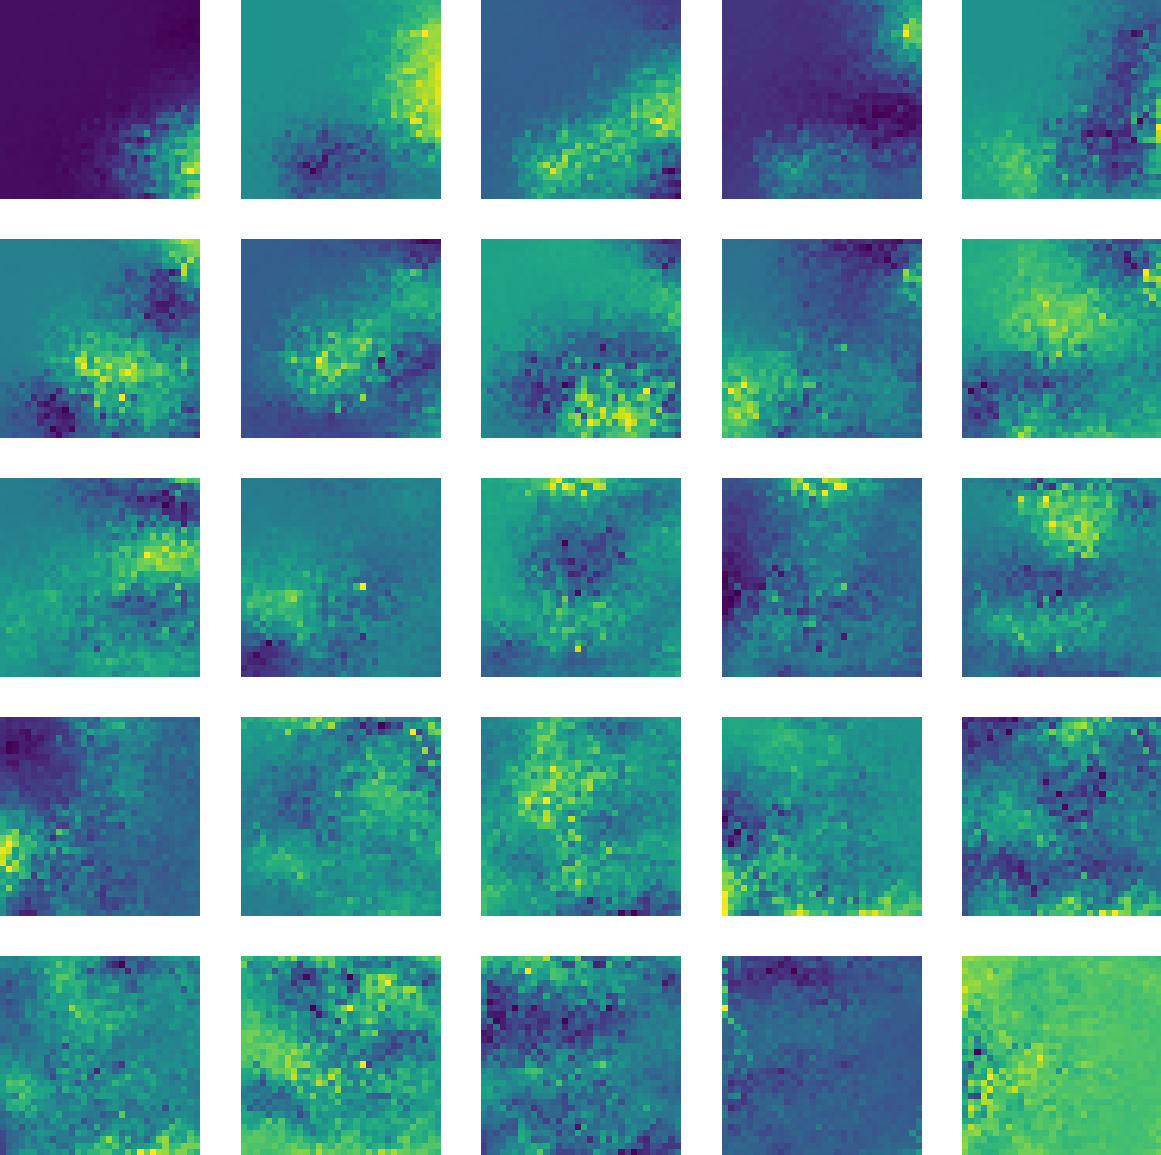

In [23]:
result = p_pca.transform(pt[pca_env].reshape(-1, pt.shape[-1]))
ratemaps = stats.ratemaps(result[None], rt[pca_env].reshape(-1, rt.shape[-1])[None], bins = [32,32])
plt.figure()
analysis_tools.plot_ensemble(ratemaps[0], 5)

In [24]:
import open3d as o3d


# Create a point cloud object
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(transformed_gc_3D)

# Compute the colors based on the z coordinate
colors = (transformed_gc_3D[:, 2] - np.min(transformed_gc_3D[:, 2])) / (np.max(transformed_gc_3D[:, 2]) - np.min(transformed_gc_3D[:, 2]))
colors = np.c_[colors, np.zeros_like(colors), 1 - colors]  # Color map: blue to red
pcd.colors = o3d.utility.Vector3dVector(colors)

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd])

ModuleNotFoundError: No module named 'open3d'